In [4]:
import numpy as np
import pandas as pd
import cv2
import os
from random import shuffle
from tqdm import tqdm
import scipy
import skimage
from skimage.transform import resize

In [5]:
print(os.listdir("C:/Users/91989/Desktop/Project/data/chest_xray/input/"))

['test', 'test.h5', 'train', 'train.h5', 'val']


In [6]:
print(os.listdir("C:/Users/91989/Desktop/Project/data/chest_xray/input/train/"))

['NORMAL', 'PNEUMONIA']


In [7]:
train_dir = "C:/Users/91989/Desktop/Project/data/chest_xray/input/train/"
test_dir = "C:/Users/91989/Desktop/Project/data/chest_xray/input/test/"

In [8]:
def get_data(Dir):
    X=[]
    y=[]
    
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            
            temp = Dir + nextdir
            
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150,150,3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)  
    return X,y

In [9]:
import h5py

In [10]:
from keras.utils.np_utils import to_categorical

num_classes = 2
image_dims = (150,150,3)
file_name = 'C:/Users/91989/Desktop/Project/data/chest_xray/input/train.h5' 

try:
    with h5py.File(file_name) as hdf:
        X_train,y_train = hdf['imgs'][:],hdf['labels'][:]
        print("Loaded images from {}".format(file_name))

except(IOError, OSError, KeyError):
    print("Error in reading {}. Processing all images...".format(file_name))
    
    X_train,y_train = get_data(train_dir)
    y_train=to_categorical(y_train,num_classes)
    
    with h5py.File(filename, 'w') as hdf:
        hdf.create_dataset('imgs', data=X_train)
        hdf.create_dataset('labels',data=y_train)

Using TensorFlow backend.


Loaded images from C:/Users/91989/Desktop/Project/data/chest_xray/input/train.h5


In [11]:
file_name = 'C:/Users/91989/Desktop/Project/data/chest_xray/input/test.h5'

try:
    with h5py.File(file_name) as hdf:
        X_test, y_test = hdf['imgs'][:], hdf['labels'][:]
    print("Loaded images from {}".format(file_name))

except(IOError, OSError, KeyError):
    print("Error in reading {}. Processing all images...".format(file_name))
    
    X_test,y_test = get_data(test_dir) 
    y_test = to_categorical(y_test, num_classes)
    
    with h5py.File(file_name,'w') as hdf:
        hdf.create_dataset('imgs', data=X_test)
        hdf.create_dataset('labels', data=y_test)

Loaded images from C:/Users/91989/Desktop/Project/data/chest_xray/input/test.h5


In [12]:
print('Training X images:{} \n  Training y labels:{}'.format(X_train.shape,y_train.shape))
print('Testing X images:{} \n  Testing y labels:{}'.format(X_test.shape,y_test.shape))

Training X images:(5216, 150, 150, 3) 
  Training y labels:(5216, 2)
Testing X images:(624, 150, 150, 3) 
  Testing y labels:(624, 2)


In [13]:
Pimages = os.listdir(train_dir+"PNEUMONIA")
Nimages = os.listdir(train_dir+"NORMAL")

In [14]:
import matplotlib.pyplot as plt

def plotter(i):
    imagep1 = cv2.imread(train_dir+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3), mode='reflect')
    imagen1 = cv2.imread(train_dir+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1,imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("_"*40)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

for i in range(1,5):
    plotter(i)

(Left) - No Pneumonia Vs (Right) - Pneumonia
________________________________________


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
________________________________________


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
________________________________________


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
________________________________________


<Figure size 1000x500 with 1 Axes>

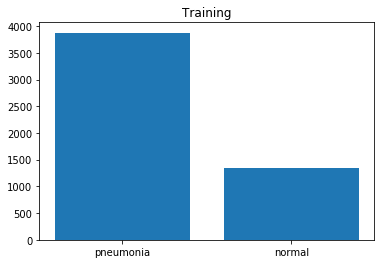

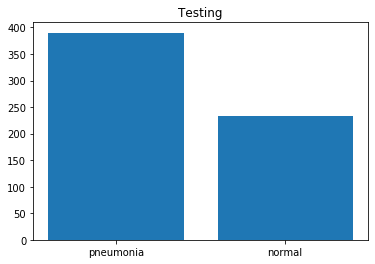

In [15]:
plt.bar(["pneumonia","normal"], [len(Pimages), len(Nimages)])
plt.title("Training")
plt.show()

Pimages_test = os.listdir(test_dir+"PNEUMONIA")
Nimages_test = os.listdir(test_dir+"NORMAL")

plt.bar(["pneumonia","normal"], [len(Pimages_test), len(Nimages_test)])
plt.title("Testing")
plt.show()

In [16]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\91989\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [17]:
filepath = "C:/Users/91989/Desktop/Jupyter_Workspace/Final_Project/Project/data/chest_xray/output/weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import Flatten,Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, RMSprop
from keras.layers import Conv2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
X_train = X_train.reshape(5216,150,150,3)
X_test = X_test.reshape(624,150,150,3)

In [20]:
from keras.layers.normalization import BatchNormalization

def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

# model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same'))
model.add(Conv2D(96, (3, 3), dilation_rate=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3), padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), dilation_rate=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.00005), metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)       

In [33]:
batch_size=256
epochs=5

In [34]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/5
5216/5216 [==============================] - ETA: 6:47 - loss: 0.0297 - accuracy: 1.00 - ETA: 6:19 - loss: 0.0306 - accuracy: 1.00 - ETA: 6:07 - loss: 0.0299 - accuracy: 1.00 - ETA: 6:05 - loss: 0.0316 - accuracy: 0.99 - ETA: 6:13 - loss: 0.0285 - accuracy: 0.99 - ETA: 6:19 - loss: 0.0282 - accuracy: 0.99 - ETA: 6:15 - loss: 0.0554 - accuracy: 0.99 - ETA: 6:11 - loss: 0.0539 - accuracy: 0.98 - ETA: 6:05 - loss: 0.0544 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0510 - accuracy: 0.98 - ETA: 6:03 - loss: 0.0478 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0467 - accuracy: 0.98 - ETA: 5:58 - loss: 0.0448 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0495 - accuracy: 0.98 - ETA: 5:54 - loss: 0.0504 - accuracy: 0.98 - ETA: 5:56 - loss: 0.0486 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0476 - accuracy: 0.98 - ETA: 6:03 - loss: 0.0457 - accuracy: 0.98 - ETA: 5:58 - loss: 0.0462 - accuracy: 0.98 - ETA: 5:58 - loss: 0.0444 - accuracy: 0.98 - ETA: 5:57 - loss: 

5216/5216 [==============================] - ETA: 5:50 - loss: 0.0107 - accuracy: 1.00 - ETA: 5:34 - loss: 0.0159 - accuracy: 0.99 - ETA: 5:23 - loss: 0.0134 - accuracy: 0.99 - ETA: 5:19 - loss: 0.0146 - accuracy: 0.99 - ETA: 5:15 - loss: 0.0317 - accuracy: 0.99 - ETA: 5:13 - loss: 0.0320 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0292 - accuracy: 0.99 - ETA: 5:10 - loss: 0.0271 - accuracy: 0.99 - ETA: 5:12 - loss: 0.0261 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0244 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0234 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0231 - accuracy: 0.99 - ETA: 4:59 - loss: 0.0216 - accuracy: 0.99 - ETA: 4:58 - loss: 0.0208 - accuracy: 0.99 - ETA: 4:59 - loss: 0.0201 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0196 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0188 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0215 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0208 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0201 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0197 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0201 - accu

5216/5216 [==============================] - ETA: 5:22 - loss: 0.0080 - accuracy: 1.00 - ETA: 5:15 - loss: 0.0063 - accuracy: 1.00 - ETA: 5:11 - loss: 0.0048 - accuracy: 1.00 - ETA: 5:09 - loss: 0.0041 - accuracy: 1.00 - ETA: 5:11 - loss: 0.0046 - accuracy: 1.00 - ETA: 5:11 - loss: 0.0047 - accuracy: 1.00 - ETA: 5:08 - loss: 0.0046 - accuracy: 1.00 - ETA: 5:05 - loss: 0.0047 - accuracy: 1.00 - ETA: 5:02 - loss: 0.0042 - accuracy: 1.00 - ETA: 5:00 - loss: 0.0039 - accuracy: 1.00 - ETA: 4:57 - loss: 0.0050 - accuracy: 1.00 - ETA: 4:55 - loss: 0.0048 - accuracy: 1.00 - ETA: 4:54 - loss: 0.0049 - accuracy: 1.00 - ETA: 4:53 - loss: 0.0059 - accuracy: 1.00 - ETA: 4:51 - loss: 0.0067 - accuracy: 0.99 - ETA: 4:48 - loss: 0.0071 - accuracy: 0.99 - ETA: 4:46 - loss: 0.0069 - accuracy: 0.99 - ETA: 4:44 - loss: 0.0067 - accuracy: 0.99 - ETA: 4:42 - loss: 0.0071 - accuracy: 0.99 - ETA: 4:40 - loss: 0.0074 - accuracy: 0.99 - ETA: 4:38 - loss: 0.0072 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0070 - accu

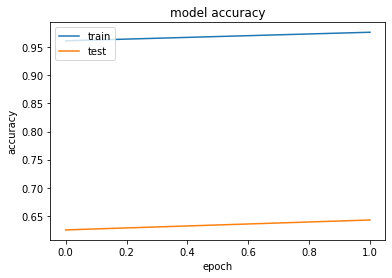

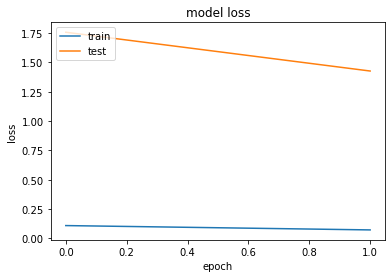

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

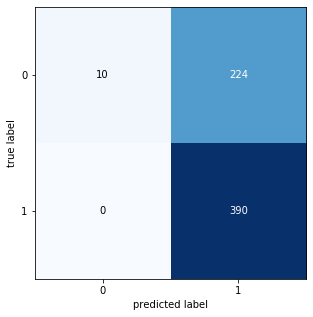

In [31]:
CM = confusion_matrix(y_true,pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5, 5))
plt.show()

In [32]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

precision = precision_score(y_true, pred)
recall = recall_score(y_true, pred)
f1 = f1_score(y_true, pred)
accuracy = accuracy_score(y_true, pred)

print('_'*40)
print("Derived Report")
print('_'*40)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("%s%.2f%s"% ("Accuracy      : ", accuracy*100,        "%"))
print('_'*40)
print("\n\n")

________________________________________
Derived Report
________________________________________
Precision     : 63.52%
Recall        : 100.00%
F1-Score      : 77.69%
Accuracy      : 64.10%
________________________________________



